# test dataset analytics

a set of functions for quickly viewing aggregate properties of a MIDI dataset

## parameters
edit these before running

In [1]:
# filesystem parameters
INPUT_DIR = "../data/datasets/20240621/play"
OUTPUT_PATH = "../data/tests"
OUTPUT_ID = "20240621"  # what identifies this run?

# dataset parameters
NUM_BEATS = 9
MIN_BPM = 50
MAX_BPM = 100

# bounds for outlier detection
OUTLIERS = {
    "min_seg_len": NUM_BEATS * 60 / MAX_BPM
    - 1,  # 9 beats per segment * 60 secs per min / 100 bpm (fastest recording tempo) - 1s for buffer = 4.4s
    "max_seg_len": NUM_BEATS * 60 / MIN_BPM
    + 1,  # 9 beats per segment * 60 secs per min / 50 bpm (slowest recording tempo) + 1s for buffer = 11.8s
    "min_note_len": 0.01,  # 10ms min note len
    "max_note_len": 12,  # 12s max note len
    "min_pitch": 0,  # lowest MIDI note, unusual
    "max_pitch": 127
    - 11,  # within an octave of the highest MIDI note, may cause issues transposing
    "min_vel": 5,  # anything quieter than this is unlikely
    "max_vel": 120,  # anything louder than this is unlikely
}

## imports

In [2]:
import os
import json
import pretty_midi
import matplotlib.pyplot as plt
from collections import Counter

## functions

In [3]:
def analyze(folder_path):
    dur_counter = Counter()
    len_counter = Counter()
    pch_counter = Counter()
    phn_counter = Counter()
    vel_counter = Counter()

    outliers = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".mid"):
            file_path = os.path.join(folder_path, file_name)

            try:
                midi = pretty_midi.PrettyMIDI(file_path)

                # count segment-level properties
                # segment length
                et = midi.get_end_time()
                len_counter[et] += 1
                if et <= OUTLIERS["min_seg_len"]:
                    print(f"short segment found w length {et:.03f}s:\t{file_name}")
                    outliers.append(
                        {
                            "file": file_name,
                            "type": "under min segment length",
                            "value": et,
                        }
                    )
                elif et >= OUTLIERS["max_seg_len"]:
                    print(f"long segment found w length {et:.03f}s:\t{file_name}")
                    outliers.append(
                        {
                            "file": file_name,
                            "type": "over max segment length",
                            "value": et,
                        }
                    )

                # segment pitch histogram
                phn = midi.get_pitch_class_histogram()
                for i, pitch in enumerate(phn):
                    phn_counter[i] += pitch

                # count note-level properties
                midi_data = pretty_midi.PrettyMIDI(file_path)
                for instrument in midi_data.instruments:
                    for note in instrument.notes:
                        # note duration
                        dt = note.end - note.start
                        dur_counter[dt] += 1
                        if dt <= OUTLIERS["min_note_len"]:
                            print(
                                f"short note found w note dur {dt:.03f}:\t{file_name}"
                            )
                            outliers.append(
                                {
                                    "file": file_name,
                                    "type": "under min note length",
                                    "value": dt,
                                }
                            )
                        elif dt >= OUTLIERS["max_note_len"]:
                            print(f"long note found w note dur {dt:.03f}:\t{file_name}")
                            outliers.append(
                                {
                                    "file": file_name,
                                    "type": "over max note length",
                                    "value": dt,
                                }
                            )
                        # note pitch
                        pch_counter[note.pitch] += 1
                        if note.pitch <= OUTLIERS["min_pitch"]:
                            print(f"low note found w pitch {note.pitch}:\t{file_name}")
                            outliers.append(
                                {
                                    "file": file_name,
                                    "type": "under min pitch",
                                    "value": note.pitch,
                                }
                            )
                        elif note.pitch >= OUTLIERS["max_pitch"]:
                            print(f"high note found w pitch {note.pitch}:\t{file_name}")
                            outliers.append(
                                {
                                    "file": file_name,
                                    "type": "over max pitch",
                                    "value": note.pitch,
                                }
                            )
                        # note velocity
                        vel_counter[note.velocity] += 1
                        if note.velocity <= OUTLIERS["min_vel"]:
                            print(
                                f"quiet note found w vel {note.velocity:03d}:\t{file_name}"
                            )
                            outliers.append(
                                {
                                    "file": file_name,
                                    "type": "under min velocity",
                                    "value": note.velocity,
                                }
                            )
                        elif note.velocity >= OUTLIERS["max_vel"]:
                            print(
                                f"loud note found w vel {note.velocity:03d}:\t{file_name}"
                            )
                            outliers.append(
                                {
                                    "file": file_name,
                                    "type": "over max velocity",
                                    "value": note.velocity,
                                }
                            )

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                outliers.append(
                    {"file": file_name, "type": "file processing error", "value": None}
                )
                continue

    return (
        len_counter,
        pch_counter,
        vel_counter,
        dur_counter,
        phn_counter,
    ), outliers

In [4]:
def plot_histogram(
    histogram,
    save_path,
    show=True,
    grid=False,
    x_label="Time (s)",
    y_label="Count",
    x_tick_labels=None,
    title=None,
) -> None:
    plt.figure(figsize=(10, 6))

    plt.bar(
        list(histogram.keys()), list(histogram.values())
    )  # , width=1.0, edgecolor="black")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(grid)

    if title:
        plt.title(title)
    if x_tick_labels:
        plt.xticks(range(len(x_tick_labels)), x_tick_labels)

    plt.savefig(save_path)

    if show:
        plt.show()
    else:
        plt.close()

## go

### calculate

In [5]:
# parameter verification
if len(os.listdir(INPUT_DIR)) < 1:
    print(f"input directory '{INPUT_DIR}' is empty")
    raise IndexError

output_dir = os.path.join(OUTPUT_PATH, OUTPUT_ID)
if os.path.isdir(output_dir):
    print(f"output folder '{output_dir}' already exists, pick a new one")
    raise IsADirectoryError

os.makedirs(output_dir)

In [6]:
(lc, pc, vc, dc, pn), outliers = analyze(INPUT_DIR)

outlier_file = os.path.join(output_dir, "outliers.json")
print(f"{len(outliers)} outliers found, writing out to '{outlier_file}'")
with open(outlier_file, "w") as f:
    json.dump(outliers, f)

quiet note found w vel 003:	20240124-064-04_0209-0217.mid
quiet note found w vel 005:	20240123-070-03_0665-0671.mid
long segment found w length 12.049s:	20240305-050-07_0172-0182.mid
quiet note found w vel 005:	20240305-050-07_0172-0182.mid
quiet note found w vel 003:	20240213-100-02_0110-0115.mid
quiet note found w vel 005:	20240123-070-03_0754-0761.mid
quiet note found w vel 003:	20240124-064-02_0644-0652.mid
long segment found w length 11.989s:	20240305-050-02_0287-0297.mid
quiet note found w vel 003:	20240124-064-02_0689-0697.mid
quiet note found w vel 005:	20240213-100-01_0076-0081.mid
quiet note found w vel 005:	20240213-100-04_0014-0019.mid
quiet note found w vel 003:	20240122-055-05_0113-0122.mid
quiet note found w vel 003:	20240511-088-03_0207-0212.mid
long segment found w length 13.152s:	20231228-072-01_0213-0219.mid
long segment found w length 12.125s:	20240305-050-07_0681-0691.mid
long segment found w length 12.561s:	20231228-072-01_0226-0233.mid
long segment found w length

### plot

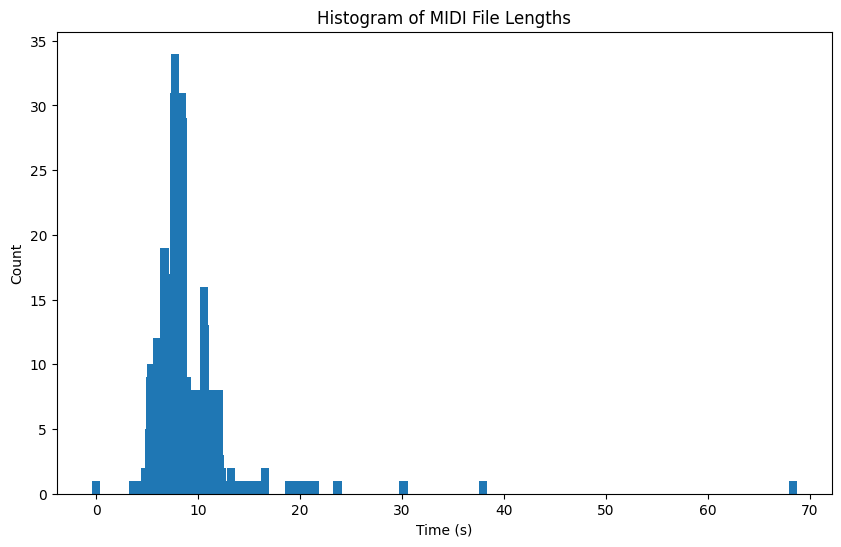

In [7]:
lc_plot_name = "segment_lengths.png"
plot_histogram(
    lc, os.path.join(output_dir, lc_plot_name), title="Histogram of MIDI File Lengths"
)

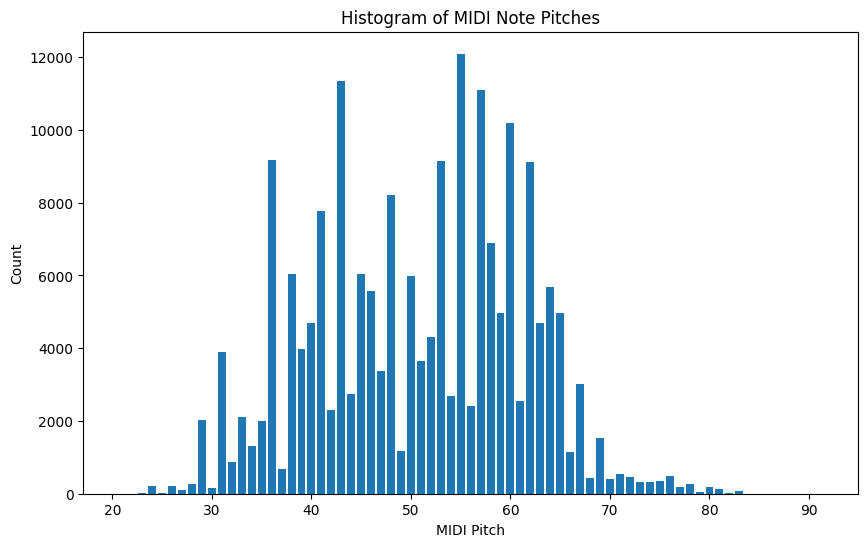

In [8]:
pc_plot_name = "pitch_counts.png"
plot_histogram(
    pc,
    os.path.join(output_dir, pc_plot_name),
    x_label="MIDI Pitch",
    title="Histogram of MIDI Note Pitches",
)

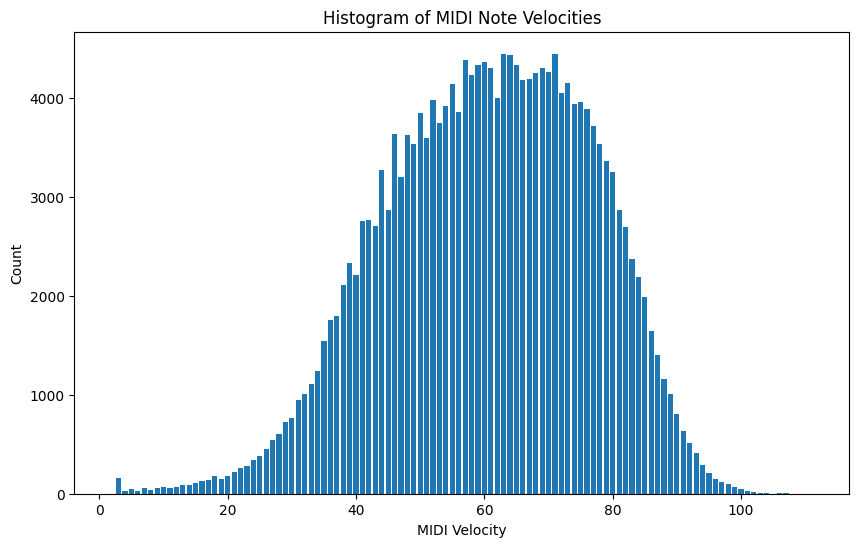

In [9]:
vc_plot_name = "velocity_counts.png"
plot_histogram(
    vc,
    os.path.join(output_dir, vc_plot_name),
    x_label="MIDI Velocity",
    title="Histogram of MIDI Note Velocities",
)

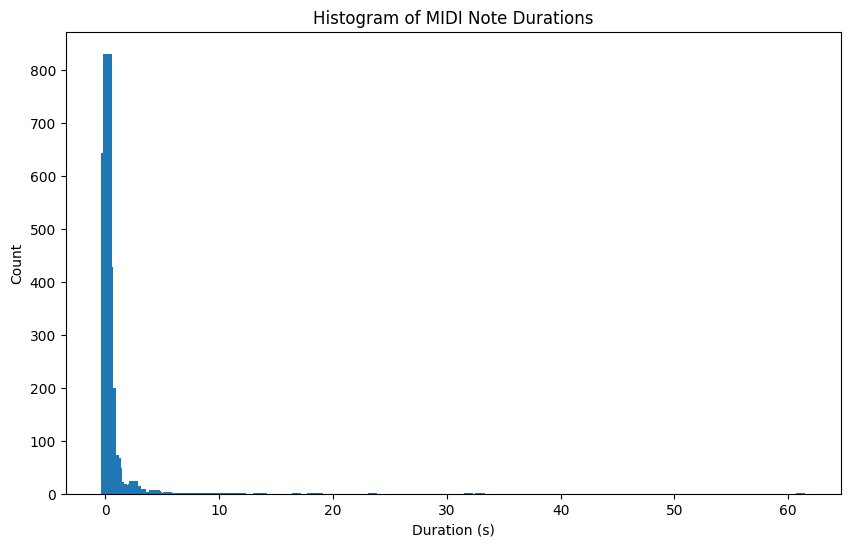

In [10]:
dc_plot_name = "duration_counts.png"
plot_histogram(
    dc,
    os.path.join(output_dir, dc_plot_name),
    x_label="Duration (s)",
    title="Histogram of MIDI Note Durations",
)

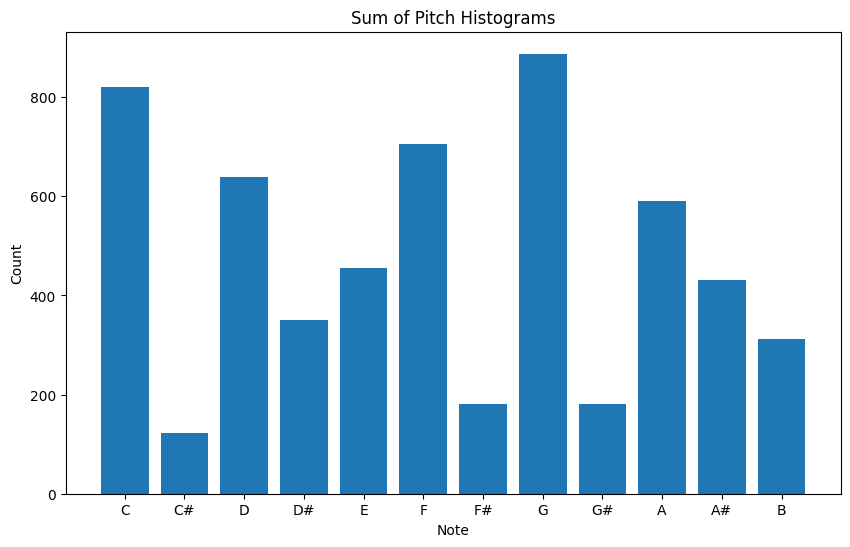

In [11]:
semitones = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
pn_plot_name = "pitch_histogram_counts.png"
plot_histogram(
    pn,
    os.path.join(output_dir, pn_plot_name),
    x_tick_labels=semitones,
    x_label="Note",
    title="Sum of Pitch Histograms",
)

### extreme outliers

In [14]:
# find empty files
for file in os.listdir("../../data/datasets/20240621/train"):
    if file.endswith(".mid"):
        midi = pretty_midi.PrettyMIDI(
            os.path.join("../../data/datasets/20240621/train", file)
        )
        note_count = 0
        for ins in midi.instruments:
            note_count += len(ins.notes)

        if note_count == 0:
            print(f"empty file found: '{file}'")
            os.remove(os.path.join("../../data/datasets/20240621/train", file))

empty file found: '20240117-064-03_0000-0007_t05s01.mid'
empty file found: '20240117-064-03_0000-0007_t09s01.mid'
empty file found: '20240117-064-03_0000-0007_t07s04.mid'
empty file found: '20240117-064-03_0000-0007_t07s05.mid'
empty file found: '20240117-064-03_0000-0007_t09s00.mid'
empty file found: '20240117-064-03_0000-0007_t05s00.mid'
empty file found: '20240117-064-03_0000-0007_t05s02.mid'
empty file found: '20240117-064-03_0000-0007_t09s02.mid'
empty file found: '20240117-064-03_0000-0007_t07s07.mid'
empty file found: '20240117-064-03_0000-0007_t07s06.mid'
empty file found: '20240117-064-03_0000-0007_t09s03.mid'
empty file found: '20240117-064-03_0000-0007_t05s03.mid'
empty file found: '20240117-064-03_0000-0007_t05s07.mid'
empty file found: '20240117-064-03_0000-0007_t07s02.mid'
empty file found: '20240117-064-03_0000-0007_t09s07.mid'
empty file found: '20240117-064-03_0000-0007_t09s06.mid'
empty file found: '20240117-064-03_0000-0007_t07s03.mid'
empty file found: '20240117-064